In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
import ast
import yaml
import json
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple
from util import count_edge_crossings

# Analysis of answers for `transpose_prompts`


In [4]:
# Some constants
WRONG_FORMAT = -1
MISSING_NODES = -2
EXTRA_NODES = -3
WRONG_RANKS = -4

## Helpers

In [5]:
def process_responses(answer_dir: str) -> Tuple[dict, dict]:
    all_answers = sorted(os.listdir(answer_dir))
    print("Number of answers:", len(all_answers))
    answers = {}
    missed = {}

    for answer_file in sorted(all_answers):
        answer_file_path = os.path.join(answer_dir, answer_file)
        answer_str = open(answer_file_path, "r").read().strip()

        # print(answer_file)
        # print(answer_str)

        # The files that contain the stirng "Copy code" contain 
        # the answer formatted in a code block.
        if "Copy code" in answer_str:
            answer_str = answer_str.split("Copy code")[1].strip()

        if "ranks =" in answer_str:
            answer_str = answer_str.split("ranks =")[1].strip()
            answer_str = answer_str.split("}")[0].strip()
            answer_str = answer_str + "}"

        try:
            answer_dict = yaml.safe_load(answer_str)
        except:
            try:
                answer_dict = json.loads(answer_str)
            except:
                try:
                    answer_dict = ast.literal_eval(answer_str)
                except:
                    missed[answer_file] = answer_str
                    continue
        
        # print(answer_dict)
        answers[answer_file] = answer_dict
        # print()
        # break

    print("Missed: ", len(missed))
    print("Answers: ", len(answers))
    return answers, missed

In [6]:
def check_nodes(answers: dict, queries: dict) -> Tuple[dict, dict, dict, dict]:
    all_nodes_queries = {}
    for query_file, query_dict in queries.items():
        all_nodes_queries[query_file] = set()
        for edge in query_dict["edges"]:
            all_nodes_queries[query_file].add(edge[0])
            all_nodes_queries[query_file].add(edge[1])

    # Print the number of nodes in the graphs of each query
    all_nodes_orig_number = [
        len(all_nodes_queries[query_file]) for query_file in all_nodes_queries
    ]
    print("\nUnique number of nodes in the graphs of each query:")
    print(np.unique(all_nodes_orig_number, return_counts=True))

    all_nodes_answers = {}
    for answer_file, answer_dict in answers.items():
        all_nodes_answers[answer_file] = set()
        for rank, nodes in answer_dict.items():
            for node in nodes:
                all_nodes_answers[answer_file].add(node)

    # Print the number of nodes in the graphs of each answer
    all_nodes_answer_number = [
        len(all_nodes_answers[answer_file]) for answer_file in all_nodes_answers
    ]
    print("\nUnique number of nodes in the graphs of each answer:")
    print(np.unique(all_nodes_answer_number, return_counts=True))

    correct_nodes_answers = {}
    incorrect_nodes_answers = {}
    for answer_file, answer_dict in answers.items():
        answer_nodes = all_nodes_answers[answer_file]
        query_nodes = all_nodes_queries[answer_file]

        if answer_nodes == query_nodes:
            correct_nodes_answers[answer_file] = answer_dict
        else:
            incorrect_nodes_answers[answer_file] = answer_dict

    print("\nCorrect nodes answers: ", len(correct_nodes_answers))
    print("Incorrect nodes answers: ", len(incorrect_nodes_answers))

    increased_nodes_answers = {}
    decreased_nodes_answers = {}

    for answer_file, answer_dict in incorrect_nodes_answers.items():
        answer_nodes = all_nodes_answers[answer_file]
        query_nodes = all_nodes_queries[answer_file]

        if len(answer_nodes) > len(query_nodes):
            increased_nodes_answers[answer_file] = answer_dict
        else:
            decreased_nodes_answers[answer_file] = answer_dict

    print("\nIncreased nodes answers: ", len(increased_nodes_answers))
    print("Decreased nodes answers: ", len(decreased_nodes_answers))

    return (
        correct_nodes_answers,
        incorrect_nodes_answers,
        increased_nodes_answers,
        decreased_nodes_answers,
    )


def check_ranks(answers: dict, queries: dict) -> Tuple[dict, dict]:
    # Check if all the answers have a correct rank assignment
    correct_rank_answers = {}
    incorrect_rank_answers = {}

    for answer_file, answer_dict in answers.items():
        query_ranks = queries[answer_file]["ranks"]
        for rank, nodes in answer_dict.items():
            if rank not in query_ranks:
                incorrect_rank_answers[answer_file] = answer_dict
                break

            query_nodes_at_rank = query_ranks[rank]
            for node in nodes:
                if node not in query_nodes_at_rank:
                    incorrect_rank_answers[answer_file] = answer_dict
                    break

        if answer_file not in incorrect_rank_answers:
            correct_rank_answers[answer_file] = answer_dict

    print("Number of correct rank answers:", len(correct_rank_answers))
    print("Number of incorrect rank answers:", len(incorrect_rank_answers))

    return correct_rank_answers, incorrect_rank_answers


In [7]:
def visualize_graph(ranks: dict, edges: list, filter_same_rank: False):
    plt.figure(figsize=(14, 5))

    edges_out_of_node = {}
    for edge in edges:
        if edge[0] not in edges_out_of_node:
            edges_out_of_node[edge[0]] = []
        edges_out_of_node[edge[0]].append(edge[1])
        if edge[1] not in edges_out_of_node:
            edges_out_of_node[edge[1]] = []
        edges_out_of_node[edge[1]].append(edge[0])

    G = nx.Graph()
    for layer_n, layer in ranks.items():
        for node in layer:
            G.add_node(node, layer=layer_n)

    pos = nx.multipartite_layout(G, subset_key="layer")
    nodes_draw = nx.draw_networkx_nodes(G, pos)
    node_labels_dict = nx.draw_networkx_labels(
        G,
        pos,
        font_color="white",
        font_weight="bold",
    )

    for layer_n, layer in ranks.items():
        for node in layer:
            if node in edges_out_of_node:
                for edge_target in edges_out_of_node[node]:
                    if filter_same_rank and edge_target in layer:
                        continue
                    G.add_edge(node, edge_target)
    edges_draw = nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    plt.show()


## Load and clean the prompts

In [8]:
queries_dir = os.path.join("queries", "transpose_prompts3")

In [9]:
queries = {}

for query_file in sorted(os.listdir(queries_dir)):
    queries[query_file] = {}
    query_file_path = os.path.join(queries_dir, query_file)

    query_str = open(query_file_path, "r").read().strip()

    query_edges = query_str.split("edges = ")[1]
    query_edges = query_edges.split("\n")[0].strip()
    query_edges = ast.literal_eval(query_edges)

    query_ranks = query_str.split("ranks = ")[1]
    query_ranks = query_ranks.split("\n\n")[0].strip()
    query_ranks = query_ranks.split("\n")
    # From each substring remove "Layer " at the 
    # beginning and add "," at the end
    query_ranks = [r[6:].strip() + "," for r in query_ranks]
    query_ranks = "".join(query_ranks)
    query_ranks = "{" + query_ranks[:-1] + "}"
    query_ranks = ast.literal_eval(query_ranks)
    
    queries[query_file]["edges"] = query_edges
    queries[query_file]["ranks"] = query_ranks

print("Number of queries: ", len(queries))

Number of queries:  134


## Load and clean the answers

In [10]:
answer_dir = os.path.join("answers", "transpose_prompts3")
answers, missed = process_responses(answer_dir)

Number of answers: 134
Missed:  4
Answers:  130


## Safety check: all nodes are there

In [11]:
(
    correct_nodes_answers,
    incorrect_nodes_answers,
    increased_nodes_answers,
    decreased_nodes_answers,
) = check_nodes(answers, queries)


Unique number of nodes in the graphs of each query:
(array([10, 11]), array([ 27, 107]))

Unique number of nodes in the graphs of each answer:
(array([10, 11]), array([ 27, 103]))

Correct nodes answers:  129
Incorrect nodes answers:  1

Increased nodes answers:  0
Decreased nodes answers:  1


In [12]:
correct_rank_answers, incorrect_rank_answers = check_ranks(correct_nodes_answers, queries)

Number of correct rank answers: 125
Number of incorrect rank answers: 4


In [13]:
results = []
for i, query in enumerate(queries):

    c = count_edge_crossings(queries[query]["edges"], queries[query]["ranks"])
    if query in correct_rank_answers:
        c2 = count_edge_crossings(queries[query]["edges"], answers[query])
    elif query in incorrect_rank_answers:
        c2 = WRONG_RANKS
    elif query in increased_nodes_answers:
        c2 = EXTRA_NODES
    elif query in decreased_nodes_answers:
        c2 = MISSING_NODES
    else:
        c2 = WRONG_FORMAT
    # print("original crossings: ", c, "new crossings: ", c2)
    results.append({
        "query": query,
        "original_crossings": c,
        "new_crossings": c2,
    })

    # break

# results_df = pd.DataFrame.from_dict(results)

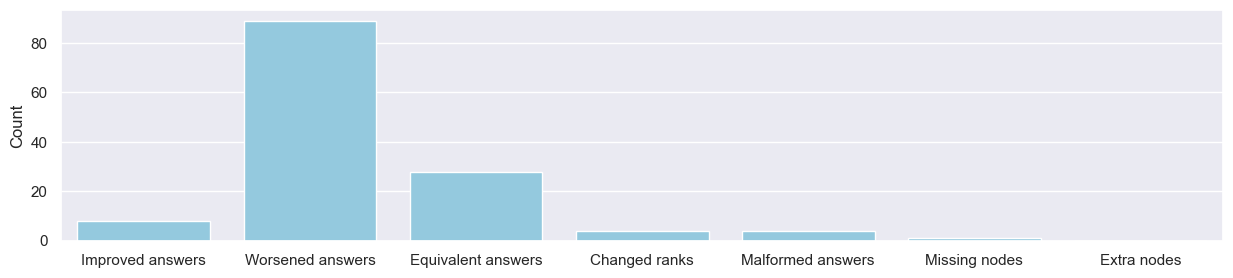

In [20]:
# Generate some sample data as a dictionary
data = {}

# Count the number of entries for which new_crossings is positive and new_crossings < original_crossings
improved_answers = list(filter(lambda x: x["new_crossings"] >= 0 and x["new_crossings"] < x["original_crossings"], results))
data["Improved answers"] = len(improved_answers)

# Count the number of entries for which new_crossings is positive and new_crossings > original_crossings
worsened_answers = list(filter(lambda x: x["new_crossings"] >= 0 and x["new_crossings"] > x["original_crossings"], results))
data["Worsened answers"] = len(worsened_answers)

# Count the number of entries for which new_crossings is positive and new_crossings == original_crossings
equivalent_answers = list(filter(lambda x: x["new_crossings"] >= 0 and x["new_crossings"] == x["original_crossings"], results))
data["Equivalent answers"] = len(equivalent_answers)

# Count the number of changed ranks
changed_ranks = list(filter(lambda x: x["new_crossings"] == WRONG_RANKS, results))
data["Changed ranks"] = len(changed_ranks)

# Count the number of malformed answers
malformed_answers = list(filter(lambda x: x["new_crossings"] == WRONG_FORMAT, results))
data["Malformed answers"] = len(malformed_answers)

# Count the number of answers with missing nodes
missing_nodes = list(filter(lambda x: x["new_crossings"] == MISSING_NODES, results))
data["Missing nodes"] = len(missing_nodes)

# Count the number of answers with extra nodes
extra_nodes = list(filter(lambda x: x["new_crossings"] == EXTRA_NODES, results))
data["Extra nodes"] = len(extra_nodes)

# Convert the dictionary to a Pandas DataFrame for plotting
df = pd.DataFrame.from_dict(data, orient='index', columns=['Value'])

sns.set(rc={'figure.figsize':(15,3)})

# Use Seaborn to create a bar chart
sns.barplot(x=df.index, y='Value', data=df, color='skyblue')

# Set the labels for the x and y axes
# plt.xSabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

In [15]:
# Debug code
# for ans in improved_answers:
#     q = ans["query"]
#     print("original ranks: ", queries[q]["ranks"])
#     print("original edges: ", queries[q]["edges"])
#     print("response ranks:", answers[q])
#     print("\n\n")
#     # break

Number of improved answers:  8
Original graph:
{0: [0], 1: [10], 2: [5, 3, 2, 6, 4, 1, 7], 3: [9, 8]} [(1, 6), (6, 2), (2, 7), (7, 3), (2, 8), (8, 4), (5, 6), (5, 9), (9, 1), (10, 5), (10, 3), (10, 2), (10, 6), (10, 4), (10, 1), (10, 0), (10, 7)]


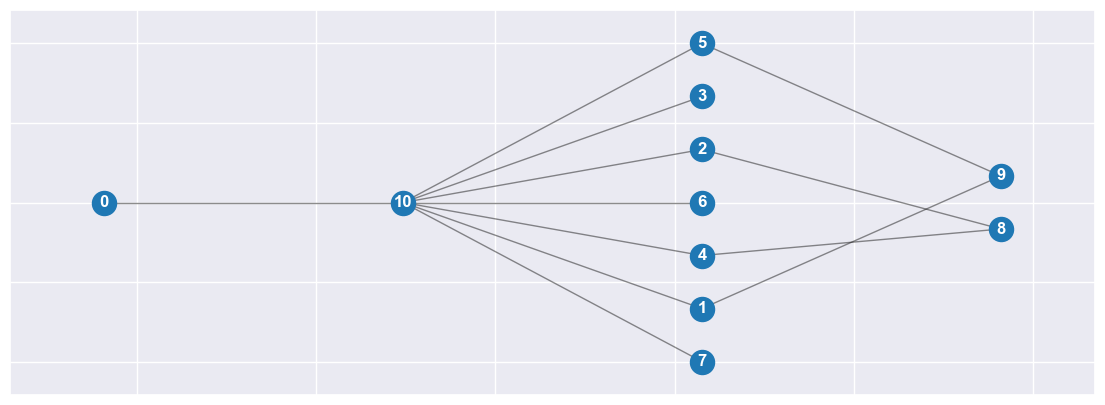

Answer graph:
{0: [0], 1: [10], 2: [5, 3, 2, 6, 1, 7, 4], 3: [9, 8]}


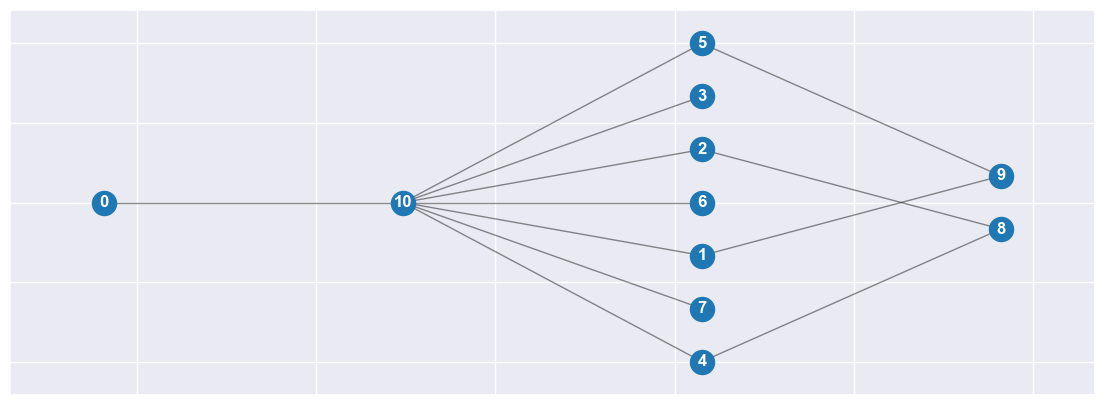




Original graph:
{0: [0], 1: [1, 3, 6], 2: [2, 5, 4, 7, 8], 3: [9]} [(0, 1), (1, 2), (2, 3), (0, 3), (5, 6), (6, 1), (1, 5), (4, 1), (4, 3), (1, 7), (0, 6), (8, 1), (9, 2), (5, 2)]


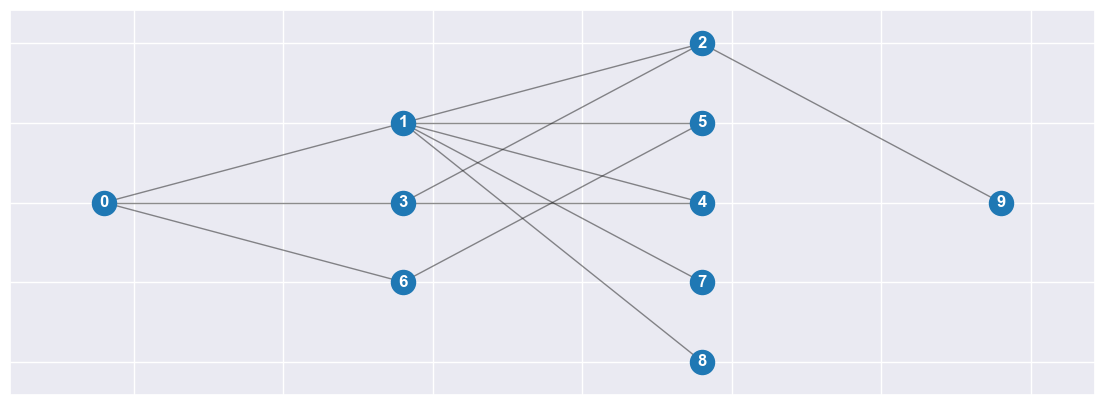

Answer graph:
{0: [0], 1: [1, 6, 3], 2: [2, 5, 7, 4, 8], 3: [9]}


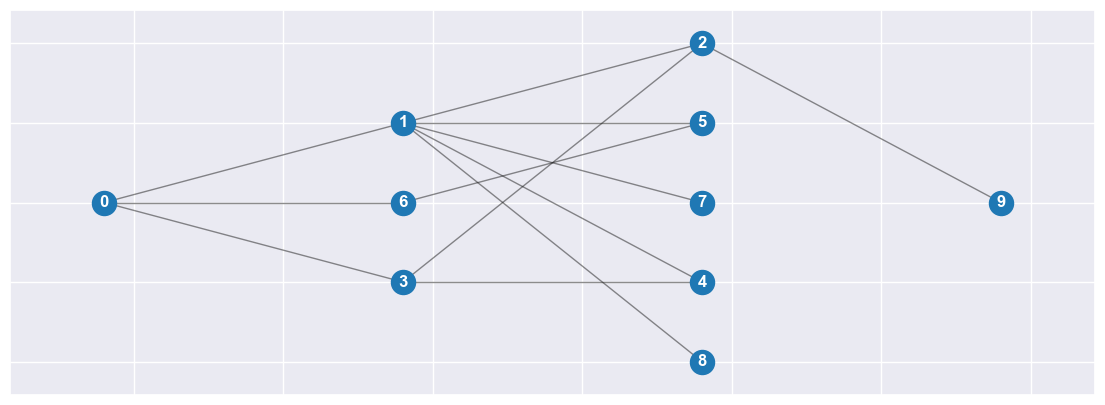




Original graph:
{0: [0], 1: [1, 7, 10], 2: [2, 4, 8, 9, 6], 3: [3, 5]} [(0, 1), (1, 2), (2, 3), (4, 5), (5, 6), (6, 7), (7, 1), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9), (7, 0), (10, 0), (10, 2), (10, 8)]


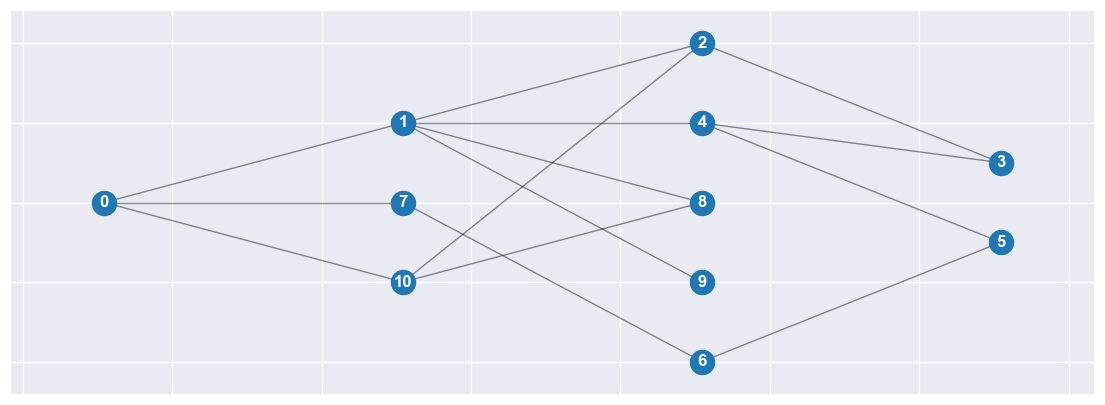

Answer graph:
{0: [0], 1: [1, 10, 7], 2: [2, 8, 9, 4, 6], 3: [3, 5]}


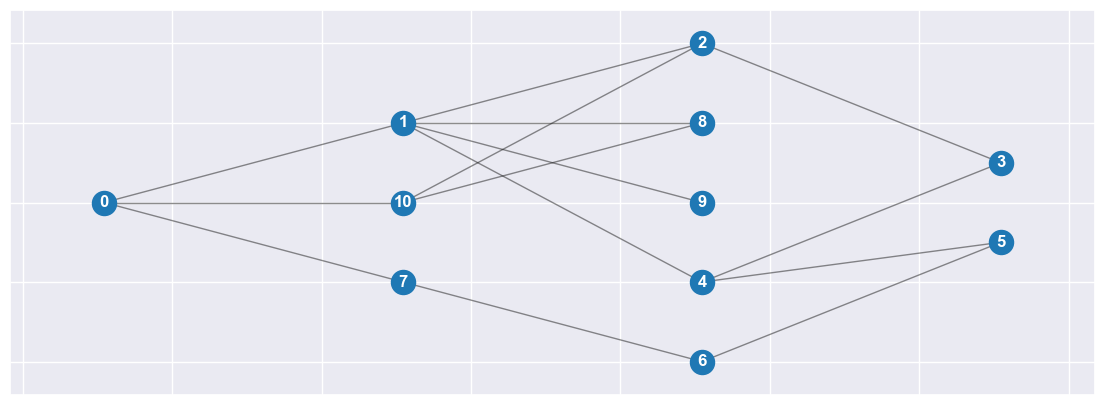




Original graph:
{0: [0], 1: [1, 2, 8], 2: [5, 6, 3, 7], 3: [9], 4: [4]} [(0, 1), (1, 2), (2, 3), (5, 1), (1, 6), (6, 7), (2, 7), (2, 0), (0, 8), (8, 3), (9, 4), (9, 5)]


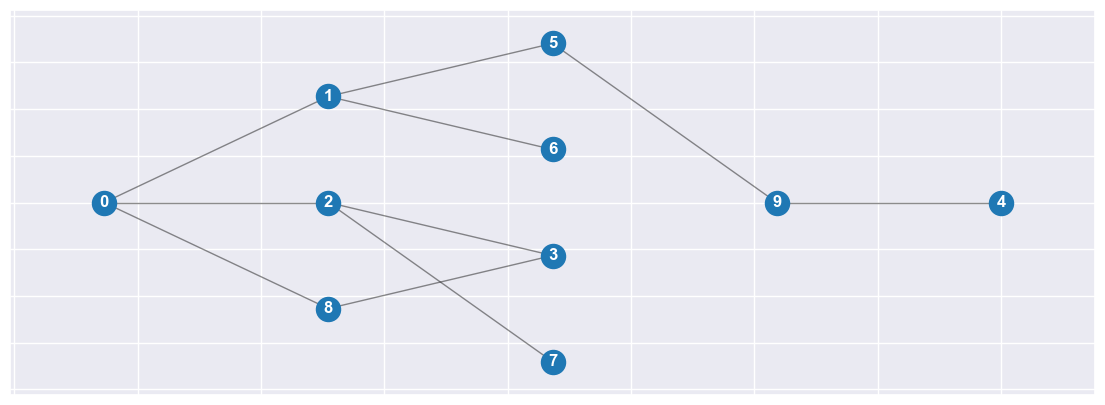

Answer graph:
{0: [0], 1: [1, 8, 2], 2: [5, 6, 3, 7], 3: [9], 4: [4]}


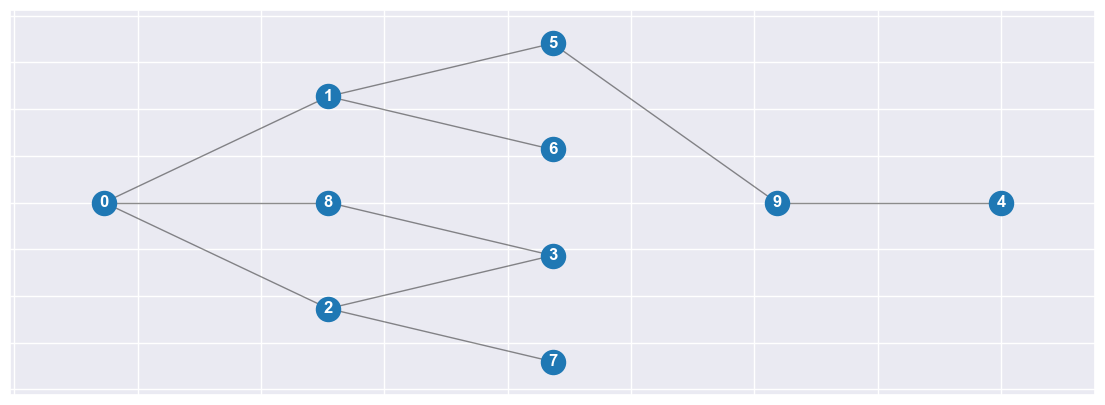




Original graph:
{0: [0], 1: [1, 3, 10], 2: [2, 7, 6, 4, 8], 3: [5, 9]} [(0, 1), (1, 2), (2, 3), (0, 3), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (8, 1), (2, 8), (2, 5), (5, 9), (9, 6), (10, 3), (10, 1), (10, 0)]


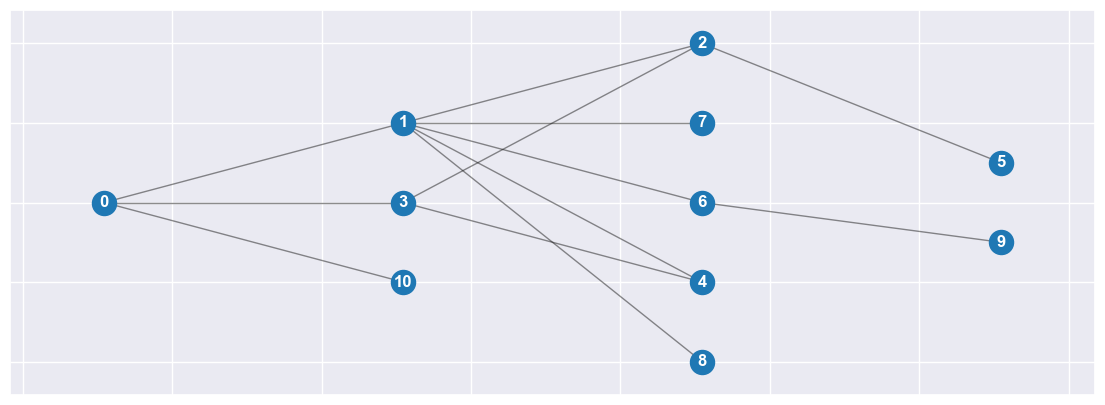

Answer graph:
{0: [0], 1: [1, 3, 10], 2: [7, 6, 2, 8, 4], 3: [5, 9]}


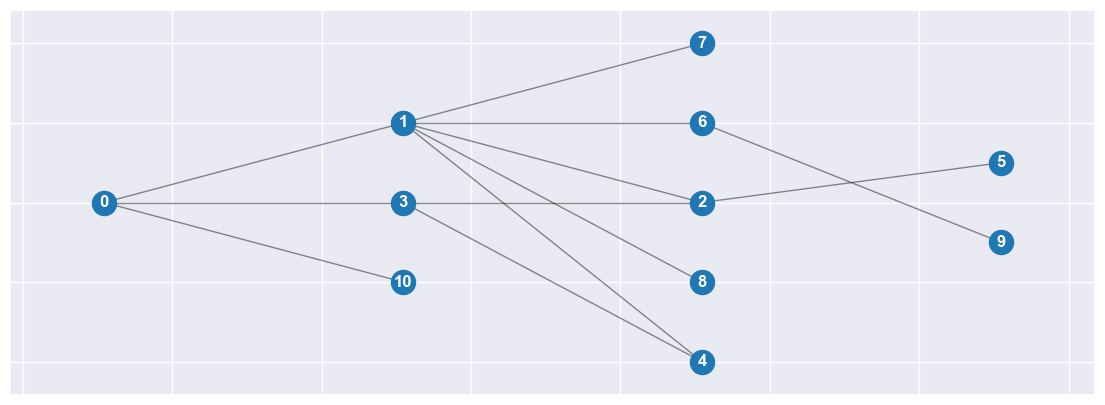




Original graph:
{0: [0], 1: [1, 3], 2: [2, 6, 4, 7, 8], 3: [10, 9, 5]} [(0, 1), (1, 2), (2, 3), (0, 3), (6, 1), (4, 1), (1, 7), (7, 8), (8, 1), (2, 8), (7, 5), (4, 9), (9, 5), (10, 6)]


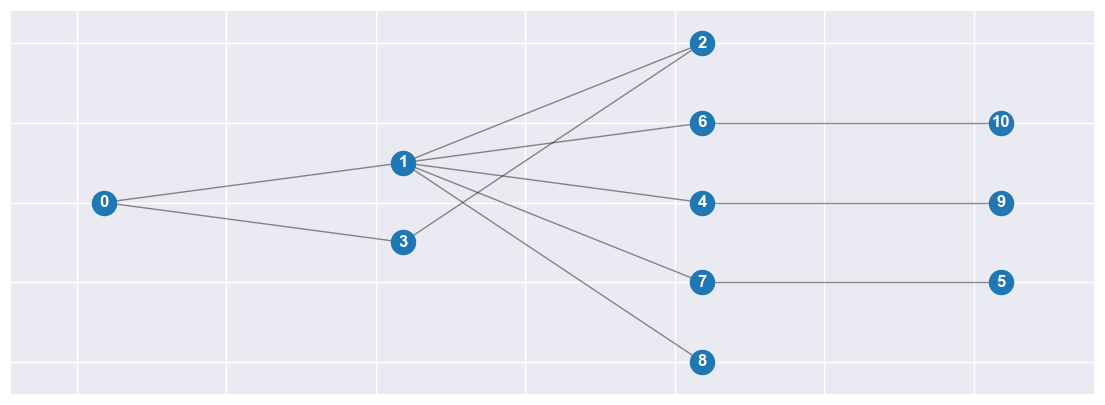

Answer graph:
{0: [0], 1: [1, 3], 2: [6, 2, 4, 8, 7], 3: [10, 9, 5]}


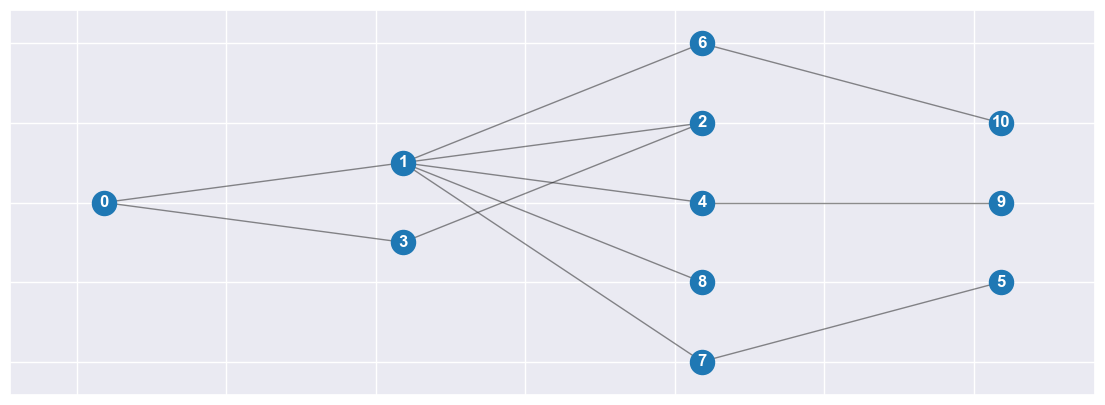




Original graph:
{0: [0], 1: [1], 2: [6, 8, 2, 9], 3: [3, 5, 4, 7], 4: [10]} [(5, 2), (1, 6), (6, 3), (0, 1), (2, 4), (7, 2), (8, 1), (8, 6), (2, 1), (1, 9), (9, 5), (10, 5), (10, 7)]


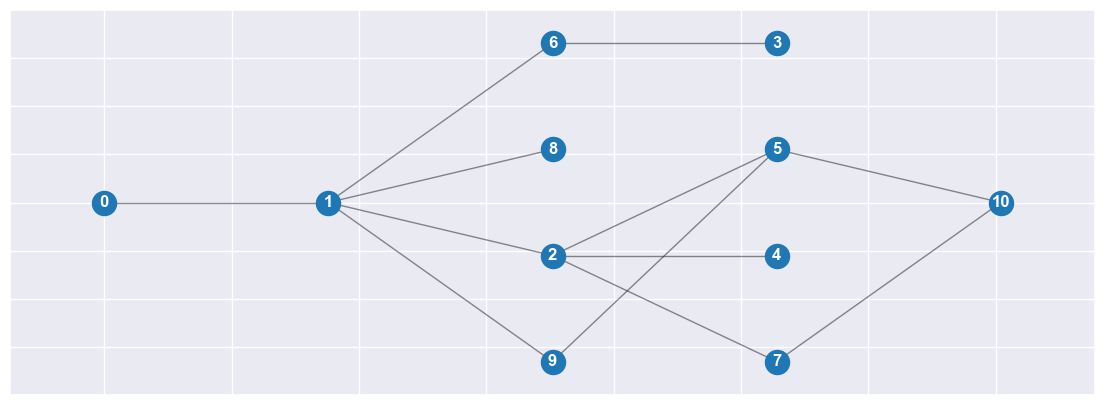

Answer graph:
{0: [0], 1: [1], 2: [6, 8, 9, 2], 3: [3, 5, 7, 4], 4: [10]}


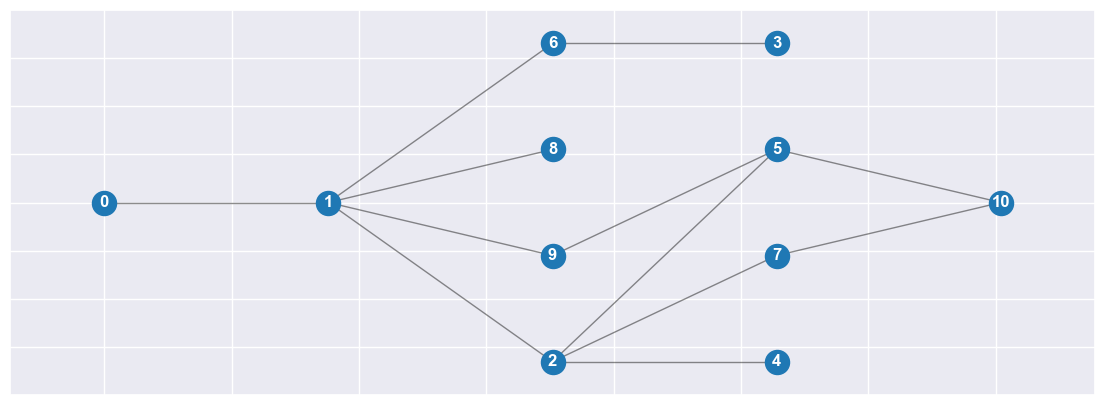




Original graph:
{0: [0], 1: [4, 5, 8], 2: [3, 1, 6, 7], 3: [9, 10, 2]} [(4, 0), (3, 5), (5, 0), (5, 1), (5, 6), (7, 2), (8, 3), (8, 0), (6, 9), (9, 3), (10, 3), (7, 5)]


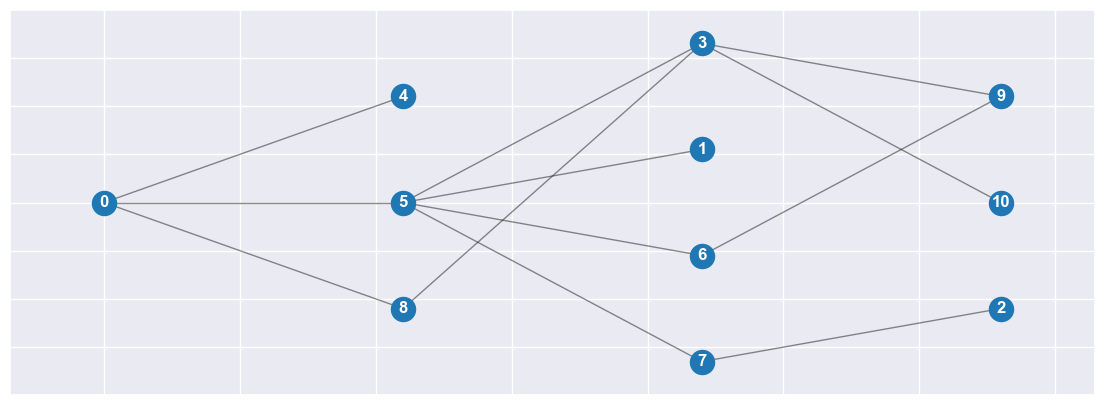

Answer graph:
{0: [0], 1: [8, 5, 4], 2: [7, 3, 1, 6], 3: [2, 10, 9]}


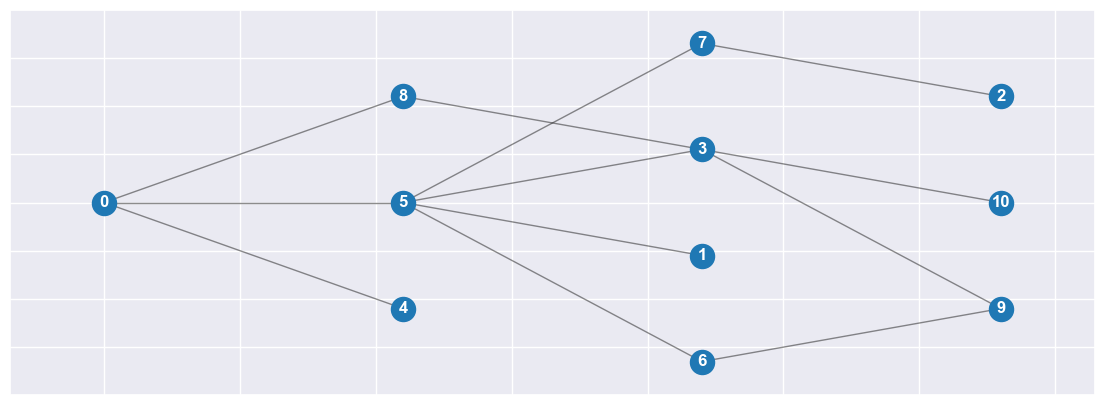

In [16]:
i = 0
print("Number of improved answers: ", len(improved_answers))
for k in improved_answers:
    q_edges = queries[k["query"]]["edges"]
    q_ranks = queries[k["query"]]["ranks"]
    r = correct_rank_answers[k["query"]]
    print("Original graph:")
    print(q_ranks, q_edges)
    visualize_graph(q_ranks, q_edges, filter_same_rank=True)
    print("Answer graph:")
    print(r)
    visualize_graph(r, q_edges, filter_same_rank=True)
    print("\n\n")
    i += 1
    # if i == 1:
    #     break

## Compare with in context learning

In [17]:
answer_dir_icl = os.path.join("answers", "transpose_prompts_icl")
all_icl = sorted(os.listdir(answer_dir_icl))
queries_icl = {q: v for q, v in queries.items() if q in all_icl}
print("Number of queries: ", len(queries_icl))
answers_icl, missed_icl = process_responses(answer_dir_icl)

(
    correct_nodes_answers_icl,
    incorrect_nodes_answers_icl,
    increased_nodes_answers_icl,
    decreased_nodes_answers_icl,
) = check_nodes(answers_icl, queries)

correct_rank_answers_icl, incorrect_rank_answers_icl = check_ranks(correct_nodes_answers_icl, queries)

results_icl = []
for i, query in enumerate(queries_icl):

    c = count_edge_crossings(queries_icl[query]["edges"], queries_icl[query]["ranks"])
    if query in correct_rank_answers_icl:
        c2 = count_edge_crossings(queries_icl[query]["edges"], answers_icl[query])
    elif query in incorrect_rank_answers_icl:
        c2 = WRONG_RANKS
    elif query in increased_nodes_answers_icl:
        c2 = EXTRA_NODES
    elif query in decreased_nodes_answers_icl:
        c2 = MISSING_NODES
    else:
        c2 = WRONG_FORMAT
    # print("original crossings: ", c, "new crossings: ", c2)
    results_icl.append({
        "query": query,
        "original_crossings": c,
        "new_crossings": c2,
    })


Number of queries:  100
Number of answers: 100
Missed:  0
Answers:  100

Unique number of nodes in the graphs of each query:
(array([10, 11]), array([ 27, 107]))

Unique number of nodes in the graphs of each answer:
(array([10, 11]), array([20, 80]))

Correct nodes answers:  100
Incorrect nodes answers:  0

Increased nodes answers:  0
Decreased nodes answers:  0
Number of correct rank answers: 97
Number of incorrect rank answers: 3


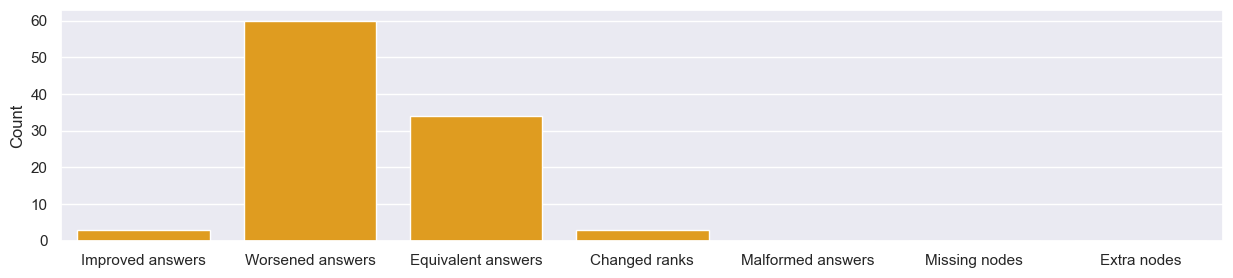

In [24]:
# Generate some sample data as a dictionary
data_icl = {}

# Count the number of entries for which new_crossings is positive and new_crossings < original_crossings
improved_answers_icl = list(filter(lambda x: x["new_crossings"] >= 0 and x["new_crossings"] < x["original_crossings"], results_icl))
data_icl["Improved answers"] = len(improved_answers_icl)

# Count the number of entries for which new_crossings is positive and new_crossings > original_crossings
worsened_answers_icl = list(filter(lambda x: x["new_crossings"] >= 0 and x["new_crossings"] > x["original_crossings"], results_icl))
data_icl["Worsened answers"] = len(worsened_answers_icl)

# Count the number of entries for which new_crossings is positive and new_crossings == original_crossings
equivalent_answers_icl = list(filter(lambda x: x["new_crossings"] >= 0 and x["new_crossings"] == x["original_crossings"], results_icl))
data_icl["Equivalent answers"] = len(equivalent_answers_icl)

# Count the number of changed ranks
changed_ranks_icl = list(filter(lambda x: x["new_crossings"] == WRONG_RANKS, results_icl))
data_icl["Changed ranks"] = len(changed_ranks_icl)

# Count the number of malformed answers
malformed_answers_icl = list(filter(lambda x: x["new_crossings"] == WRONG_FORMAT, results_icl))
data_icl["Malformed answers"] = len(malformed_answers_icl)

# Count the number of answers with missing nodes
missing_nodes_icl = list(filter(lambda x: x["new_crossings"] == MISSING_NODES, results_icl))
data_icl["Missing nodes"] = len(missing_nodes_icl)

# Count the number of answers with extra nodes
extra_nodes_icl = list(filter(lambda x: x["new_crossings"] == EXTRA_NODES, results_icl))
data_icl["Extra nodes"] = len(extra_nodes_icl)

# Convert the dictionary to a Pandas DataFrame for plotting
df_icl = pd.DataFrame.from_dict(data_icl, orient='index', columns=['Value'])

sns.set(rc={'figure.figsize':(15,3)})

# Use Seaborn to create a bar chart
sns.barplot(x=df_icl.index, y='Value', data=df_icl, color='orange')

# Set the labels for the x and y axes
# plt.xSabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

Number of improved answers:  3
Original graph: grafo1657.10.txt
{0: [0], 1: [1, 3], 2: [2, 7, 6, 4, 8, 9], 3: [5]} [(0, 1), (1, 2), (2, 3), (0, 3), (4, 5), (5, 6), (6, 7), (7, 1), (1, 6), (4, 1), (4, 3), (1, 8), (8, 9), (9, 1), (2, 9)]


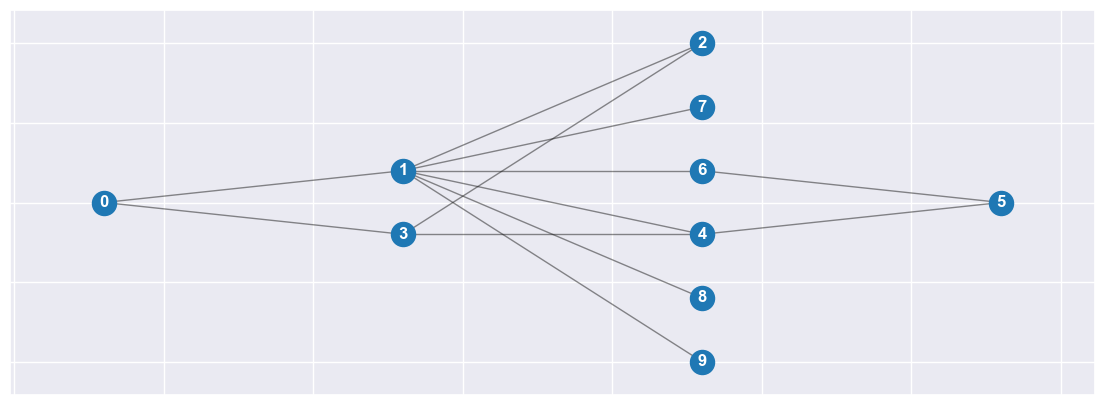

Answer graph:
{0: [0], 1: [3, 1], 2: [2, 4, 6, 7, 8, 9], 3: [5]}


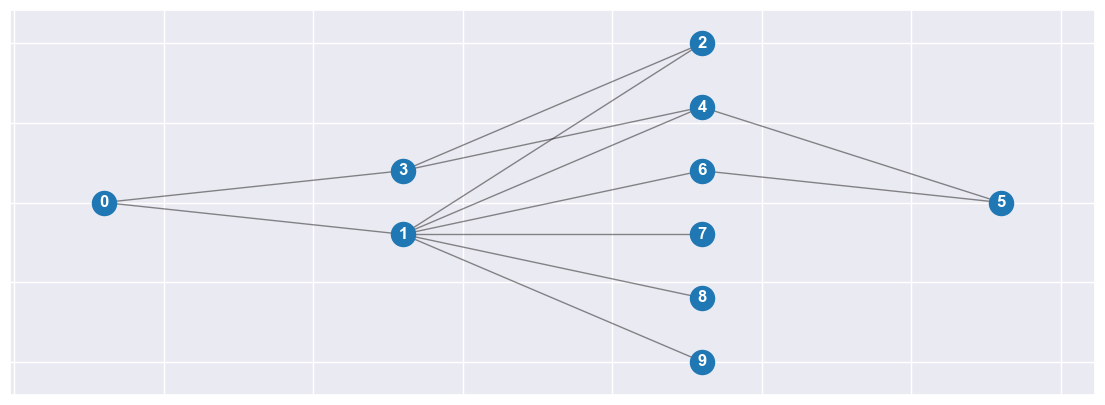




Original graph: grafo368.11.txt
{0: [0], 1: [6], 2: [5], 3: [3, 2, 9], 4: [7, 8, 10, 1], 5: [4]} [(1, 4), (6, 0), (5, 3), (3, 7), (7, 2), (8, 3), (5, 2), (6, 5), (1, 9), (9, 5), (10, 1), (10, 7), (10, 3)]


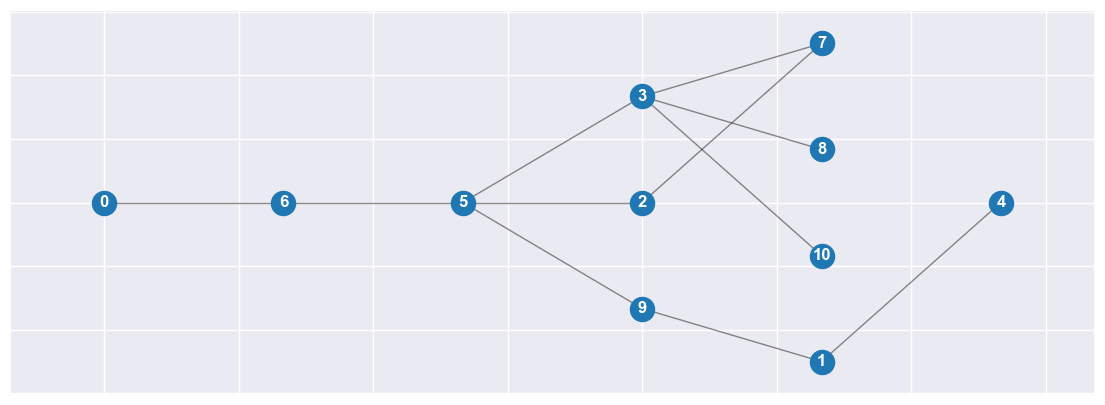

Answer graph:
{0: [0], 1: [6], 2: [5], 3: [2, 9, 3], 4: [1, 7, 8, 10], 5: [4]}


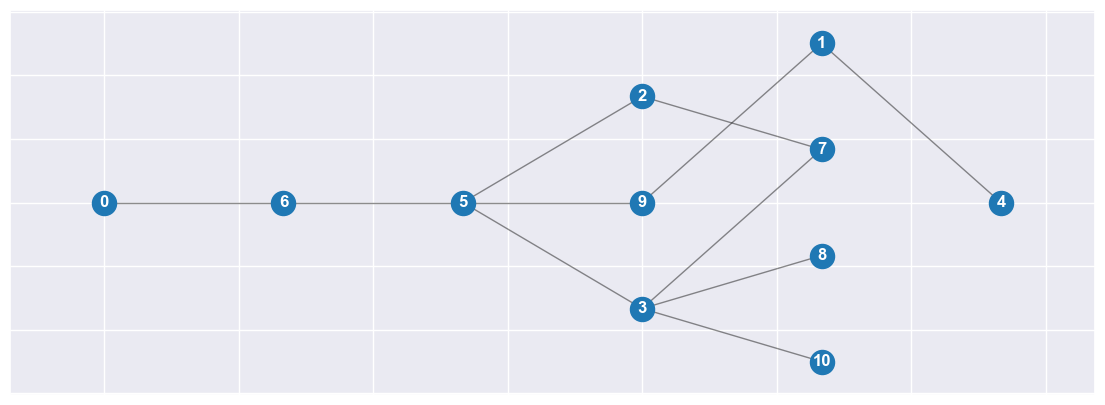




Original graph: grafo949.10.txt
{0: [0], 1: [7], 2: [2], 3: [6, 8, 5], 4: [1, 3], 5: [9], 6: [4]} [(5, 1), (1, 6), (6, 2), (2, 7), (7, 0), (3, 8), (8, 2), (4, 9), (9, 3), (2, 5)]


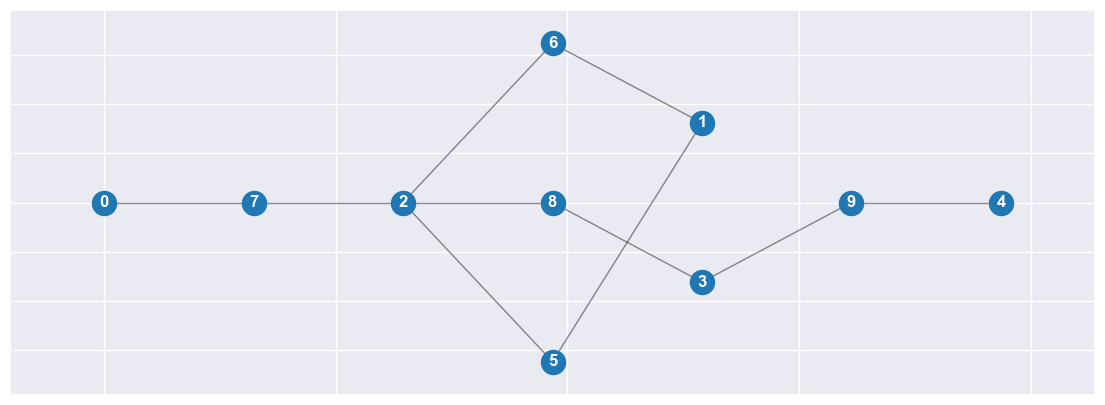

Answer graph:
{0: [0], 1: [7], 2: [2], 3: [5, 6, 8], 4: [1, 3], 5: [9], 6: [4]}


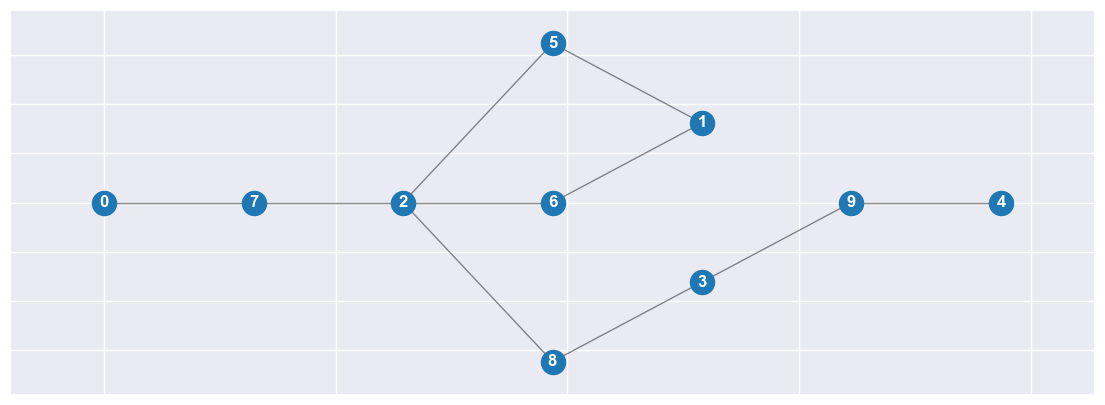

In [19]:
i = 0
print("Number of improved answers: ", len(improved_answers_icl))
for k in improved_answers_icl:
    q_edges = queries[k["query"]]["edges"]
    q_ranks = queries[k["query"]]["ranks"]
    r = correct_rank_answers_icl[k["query"]]
    print("Original graph: {}".format(k["query"]))
    print(q_ranks, q_edges)
    visualize_graph(q_ranks, q_edges, filter_same_rank=True)
    print("Answer graph:")
    print(r)
    visualize_graph(r, q_edges, filter_same_rank=True)
    print("\n\n")
    i += 1
    # if i == 1:
    #     break

### Comparison in percentages

In [26]:
df_pt = df / len(queries) * 100
df_icl_pt = df_icl / len(queries_icl) * 100

In [39]:
df_pt["Type"] = "Standard"
df_icl_pt["Type"] = "ICL"
to_plot = pd.concat([df_pt, df_icl_pt]).reset_index()
display(to_plot)

,index,Value,Type
0,Improved answers,5.970149,Standard
1,Worsened answers,66.417910,Standard
2,Equivalent answers,20.895522,Standard
3,Changed ranks,2.985075,Standard
4,Malformed answers,2.985075,Standard
5,Missing nodes,0.746269,Standard
6,Extra nodes,0.000000,Standard
7,Improved answers,3.000000,ICL
8,Worsened answers,60.000000,ICL
9,Equivalent answers,34.000000,ICL


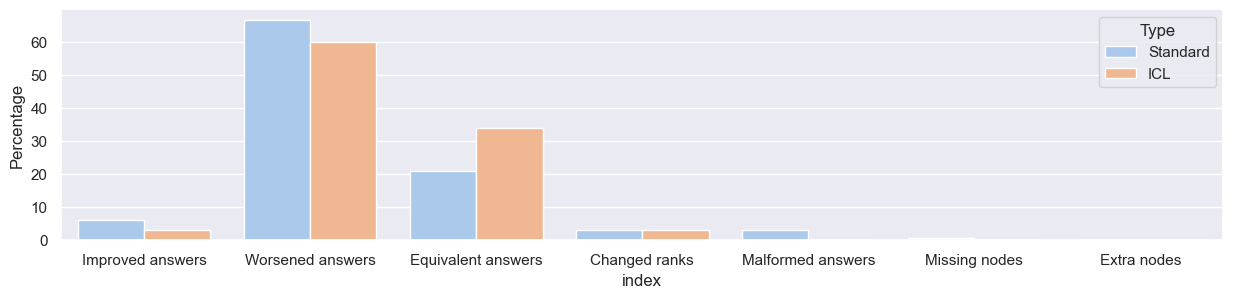

In [42]:
sns.set(rc={'figure.figsize':(15,3)})

sns.barplot(x="index", y='Value', data=to_plot, hue='Type', palette="pastel")

# Set the labels for the x and y axes
plt.ylabel('Percentage')

# Show the plot
plt.show()